# Titanic
<br>
ref: https://www.kaggle.com/ash316/eda-to-prediction-dietanic

In [1]:
from pandas import DataFrame, Series, crosstab
import numpy as np
from collections import Counter
import math
import pandas as pd
from datetime import datetime, timedelta 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold

<br>
<br>
### Loding training data and testing data

In [43]:
df = DataFrame.from_csv("res/train.csv")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<br>
### Type of feature
* Categorical Features: Sex, Embarked
* Ordinal Features: PClass(1/2/3等艙位)
* Continous Feature: Age, Fare
* Discrete Feature: SibSp


p.s.
* SibSp => 堂兄弟/妹個數
* Parch => 父母與小孩個數
* Ticket => 船票信息
* Fare => 票價
* Cabin => 客艙
* Embarked => 登船港口

In [3]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#checking for total null values
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
survived = dict(Counter(df['Survived']))
survived.values()

dict_values([549, 342])

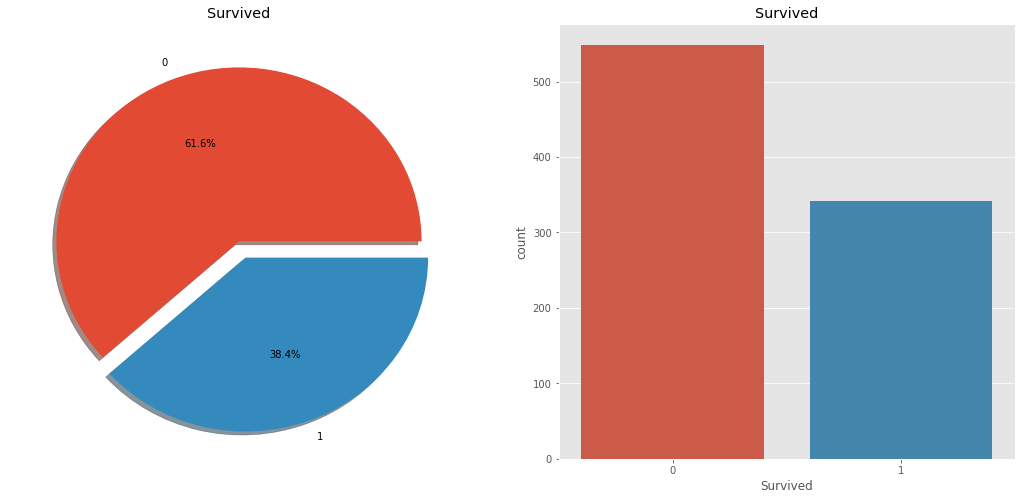

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

<br>
## Feature exploration

<br>
<b> Sex

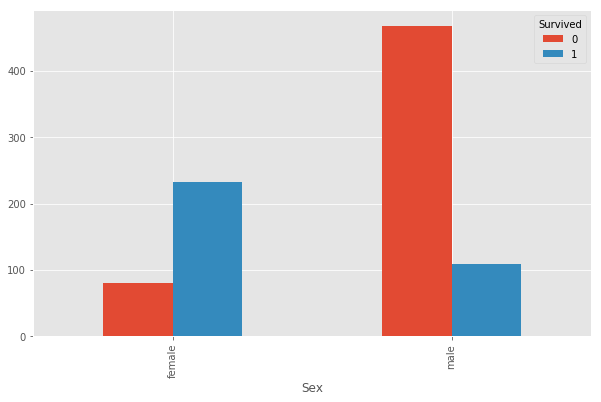

In [7]:
df_sex = crosstab(df['Sex'], df['Survived'])
df_sex.plot(kind='bar', figsize=(10,6))

<br>
<b> Pclass

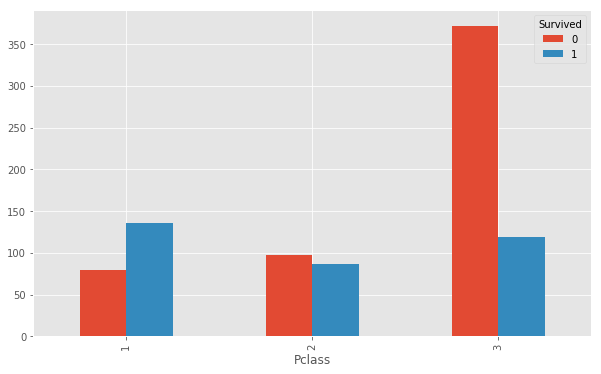

In [8]:
df_pclass = crosstab(df['Pclass'], df['Survived'])
df_pclass.plot(kind='bar', figsize=(10,6))

In [9]:
pd.crosstab(df.Pclass,df.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


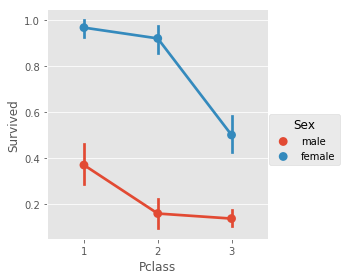

In [10]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df)
plt.show()

<br>
<b> SibSp

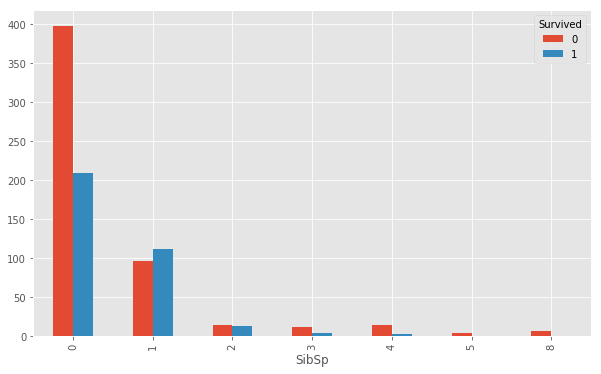

In [11]:
df_sibsp = crosstab(df['SibSp'], df['Survived'])
df_sibsp.plot(kind='bar', figsize=(10,6))

<br>
<b>Age

In [12]:
get_title = lambda x: x.split(', ')[1].split('.')[0]
df['Title'] = df['Name'].apply(get_title)
pd.crosstab(df.Sex,df.Title,margins=False).style.background_gradient(cmap='summer_r')

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [13]:
df.groupby('Title')['Age'].mean()   # Average Age

Title
Capt            70.000000
Col             58.000000
Don             40.000000
Dr              42.000000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           4.574167
Miss            21.773973
Mlle            24.000000
Mme             24.000000
Mr              32.368090
Mrs             35.898148
Ms              28.000000
Rev             43.166667
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

In [14]:
def transfer_title(x):
    if x in ['Dr','Major','Capt','Sir','Don']: return 'Mr_old'
    elif x in ['Lady','the Countess']: return 'Mrs'
    elif x in ['Mlle','Mme','Ms']: return 'Miss'
    elif x in ['Jonkheer','Col','Rev']: return 'Other'
    else: return x

df['Title'] = df['Title'].apply(transfer_title)
avg_age = df.groupby('Title')['Age'].mean()   # Average Age
avg_age

Title
Master     4.574167
Miss      21.860000
Mr        32.368090
Mr_old    46.181818
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

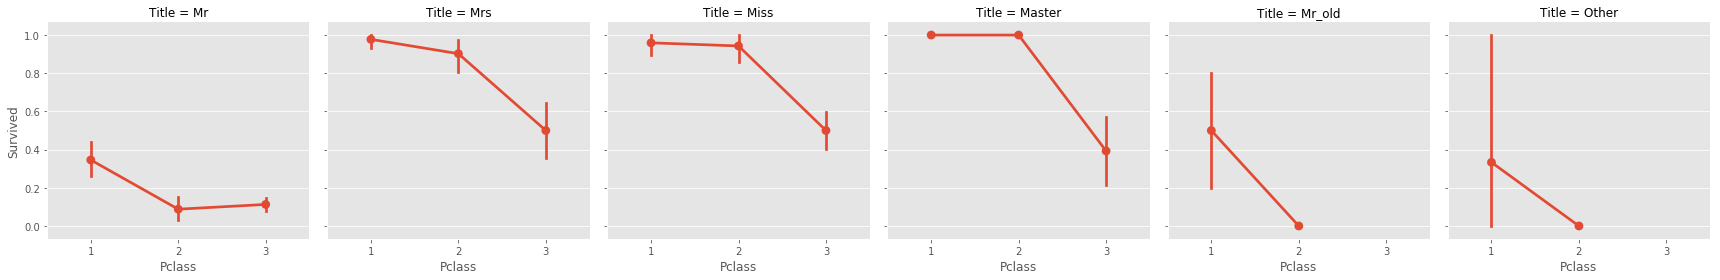

In [15]:
sns.factorplot('Pclass','Survived',col='Title',data=df)
plt.show()

In [16]:
def fill_age(age, Name):
    title = get_title(Name)
    title = transfer_title(title)
    if math.isnan(age): return avg_age[title]
    else: return age

df['Age'] = [fill_age(age, name) for age, name in zip(df['Age'], df['Name'])]

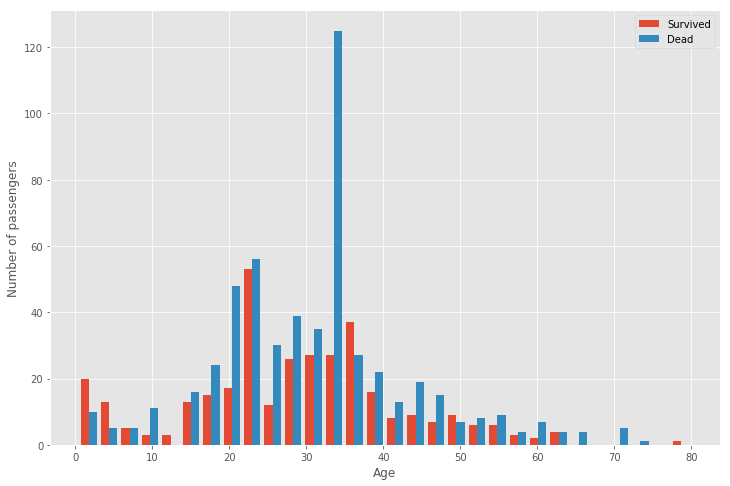

In [17]:
df['Dead'] = (df['Survived'] == 0).astype(int)
figure = plt.figure(figsize=(12,8))
plt.hist([df[df['Survived']==1]['Age'], df[df['Survived']==0]['Age']],
          bins = 30,label = ['Survived','Dead'])

plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

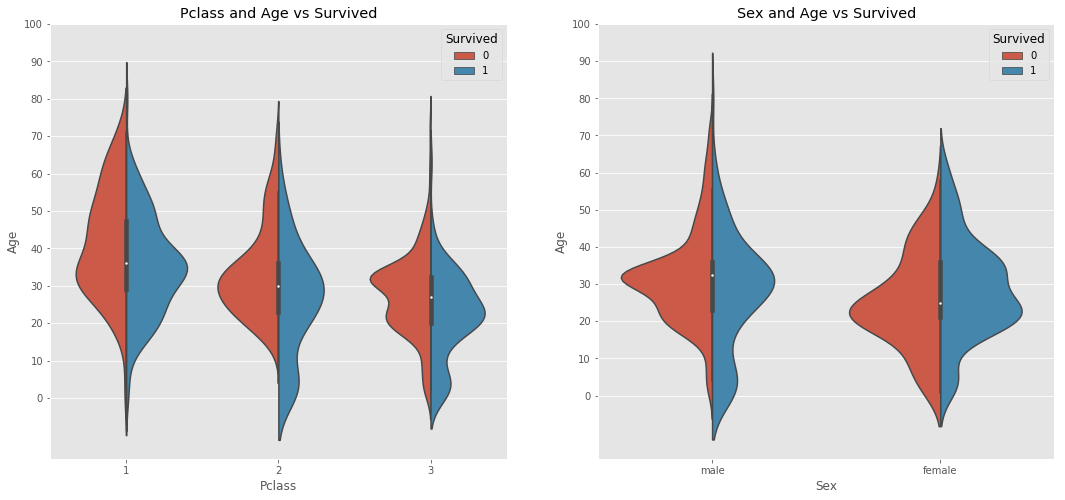

In [18]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

<br>
<b>Fare

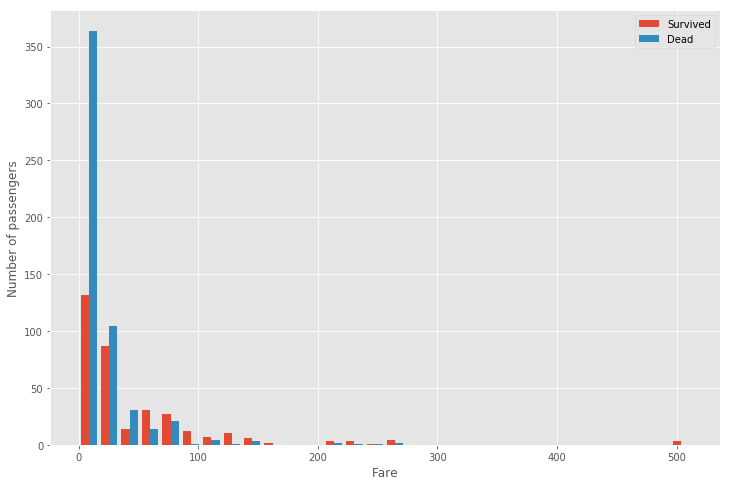

In [19]:
df['Dead'] = (df['Survived'] == 0).astype(int)
figure = plt.figure(figsize=(12,8))
plt.hist([df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare']],
          bins = 30,label = ['Survived','Dead'])

plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()
del df['Dead']

In [20]:
def sex_translate(x):
    if x == 'male': return 0
    else: return 1
    
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.764424,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.280913,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.860000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.981818,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<br>
### Embarked (categorical data)

In [21]:
pd.crosstab([df.Embarked,df.Pclass],
            [df.Sex,df.Survived],margins=True).style.background_gradient(cmap='summer_r')


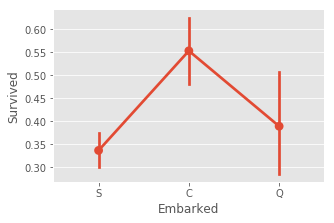

In [22]:
sns.factorplot('Embarked','Survived',data=df)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

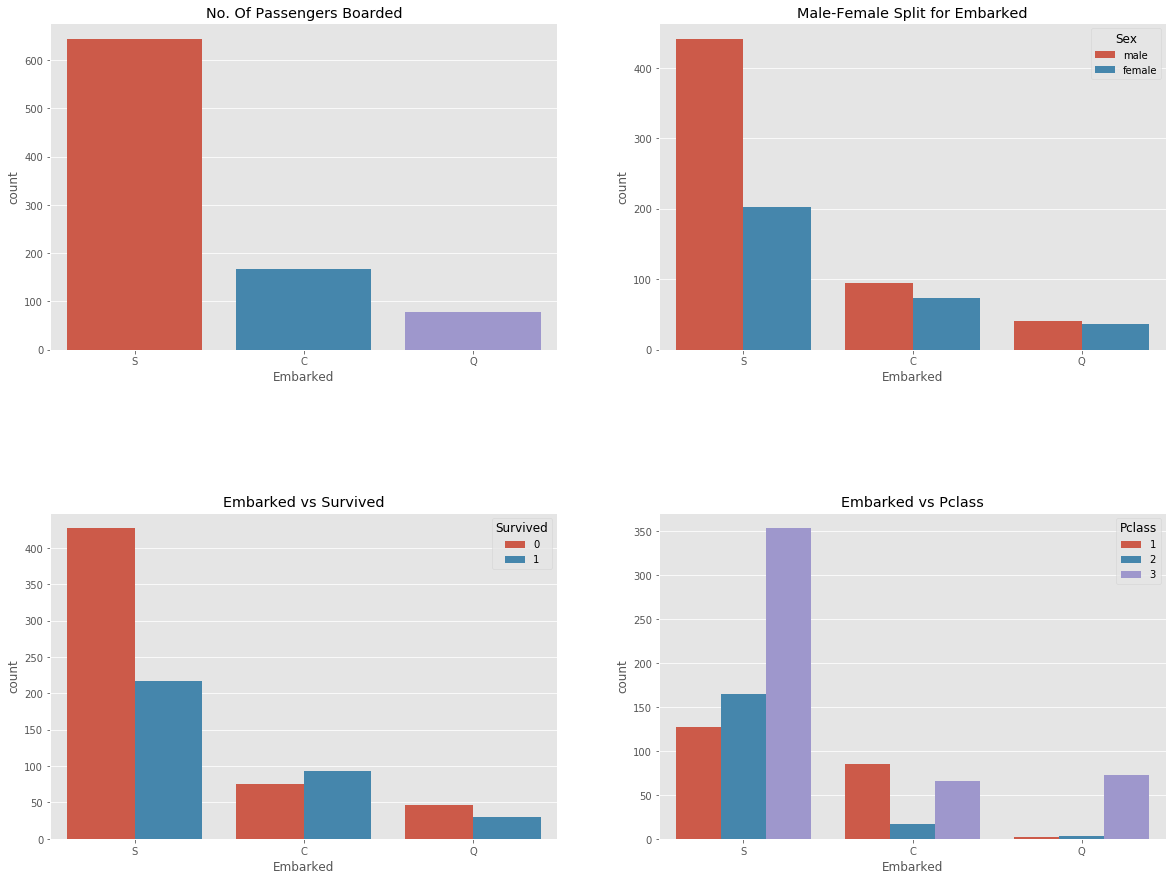

In [23]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=df,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=df,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=df,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=df,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

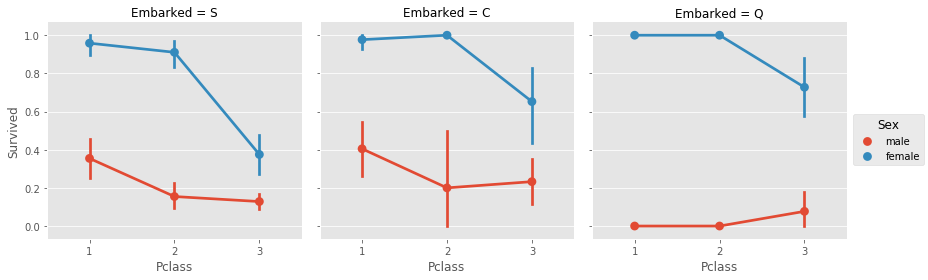

In [24]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=df)
plt.show()

<br>
### SibSp (discrete)

In [25]:
pd.crosstab([df.SibSp],df.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


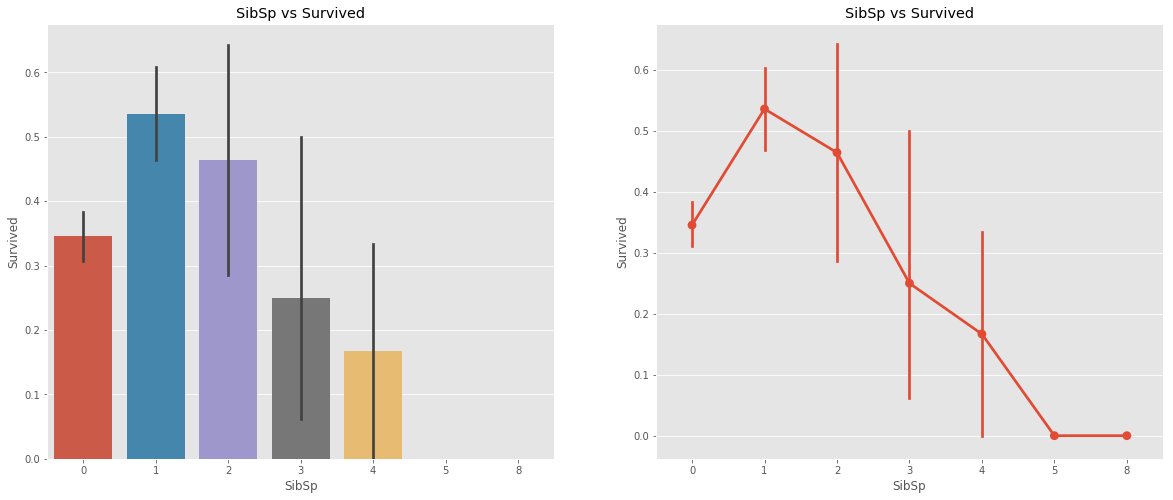

In [26]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=df,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=df,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [27]:
pd.crosstab(df.SibSp,df.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


<br>
### Parch

In [28]:
pd.crosstab(df.Parch,df.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


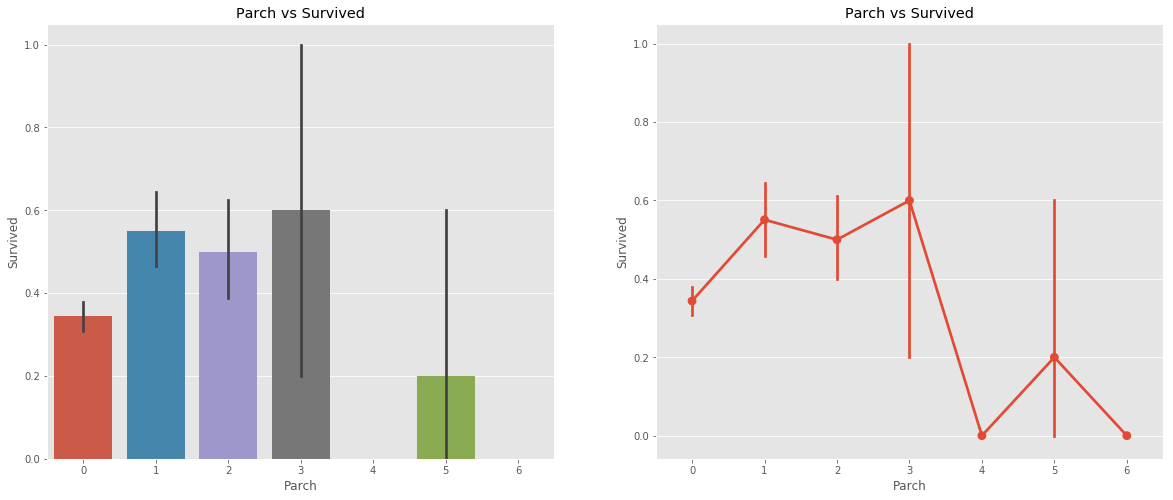

In [29]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=df,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=df,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

<br>
### Fare (Continuous Feature)

In [30]:
print('Highest Fare was:',df['Fare'].max())
print('Lowest Fare was:',df['Fare'].min())
print('Average Fare was:',df['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079686


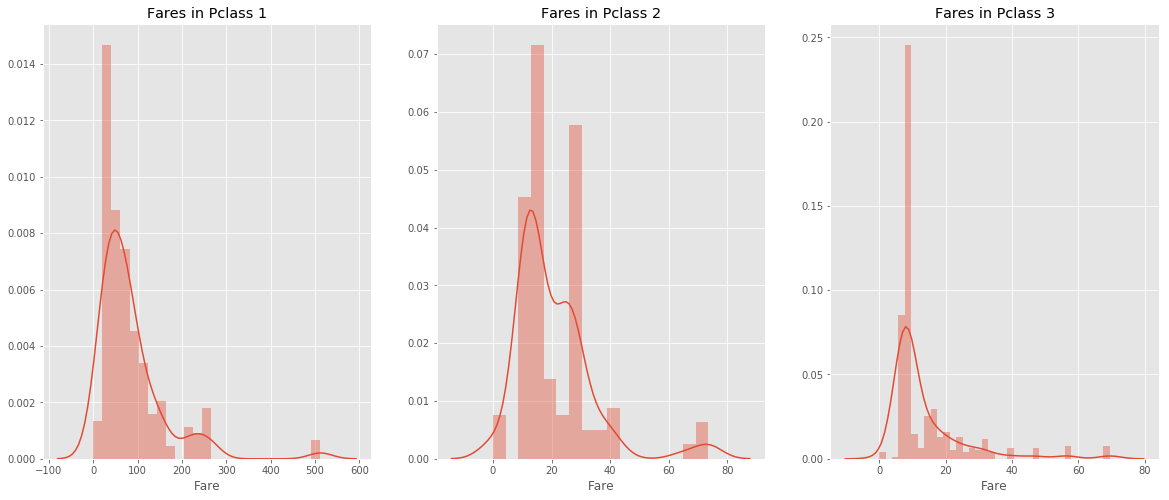

In [31]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(df[df['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(df[df['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(df[df['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

## Observations in a Nutshell for all features:
**Sex:** The chance of survival for women is high as compared to men.

**Pclass:**There is a visible trend that being a **1st class passenger** gives you better chances of survival. The survival rate for **Pclass3 is very low**. For **women**, the chance of survival from **Pclass1** is almost 1 and is high too for those from **Pclass2**.   **Money Wins!!!**. 

**Age:** Children less than 5-10 years do have a high chance of survival. Passengers between age group 15 to 35 died a lot.

**Embarked:** This is a very interesting feature. **The chances of survival at C looks to be better than even though the majority of Pclass1 passengers got up at S.** Passengers at Q were all from **Pclass3**. 

**Parch+SibSp:** Having 1-2 siblings,spouse on board or 1-3 Parents shows a greater chance of probablity rather than being alone or having a large family travelling with you.

<br>
# Correlation Between Features

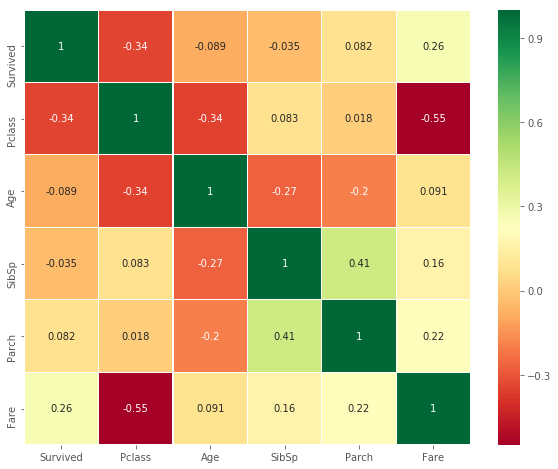

In [32]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### Interpreting The Heatmap

The first thing to note is that <b>only the numeric features are compared as it is obvious that we cannot correlate between alphabets or strings.</b> Before understanding the plot, let us see what exactly correlation is.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as **MultiColinearity** as both of them contains almost the same information.

So do you think we should use both of them as **one of them is redundant**. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between **SibSp and Parch i.e 0.41**. So we can carry on with all features.

<br>
# Feature Engineering and Data Cleaning

<br>
### Continuous data to Ordinal data

In [92]:
# Age_Band

age_cnum = 5
df['Age_Band'] = pd.cut(df['Age'],age_cnum)   # pd.cut split the range evenlydata['Fare_Range']=pd.qcut(data['Fare'],4)
df['Age_Band'].value_counts().to_frame().style.background_gradient(cmap='summer_r')

,Age_Band
"(16.336, 32.252]",346
"(32.252, 48.168]",188
"(0.34, 16.336]",100
"(48.168, 64.084]",69
"(64.084, 80.0]",11


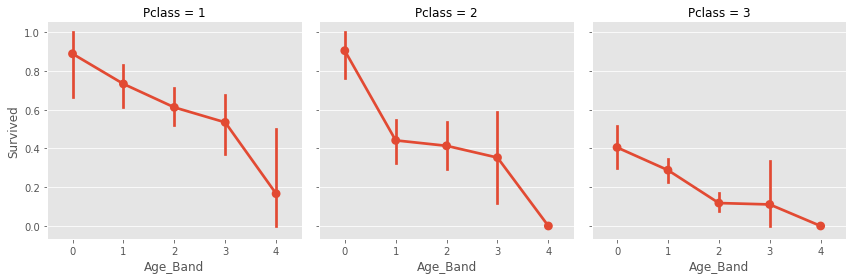

In [34]:
sns.factorplot('Age_Band','Survived',col='Pclass',data=df)
plt.show()

<br>
### Family size and Alone

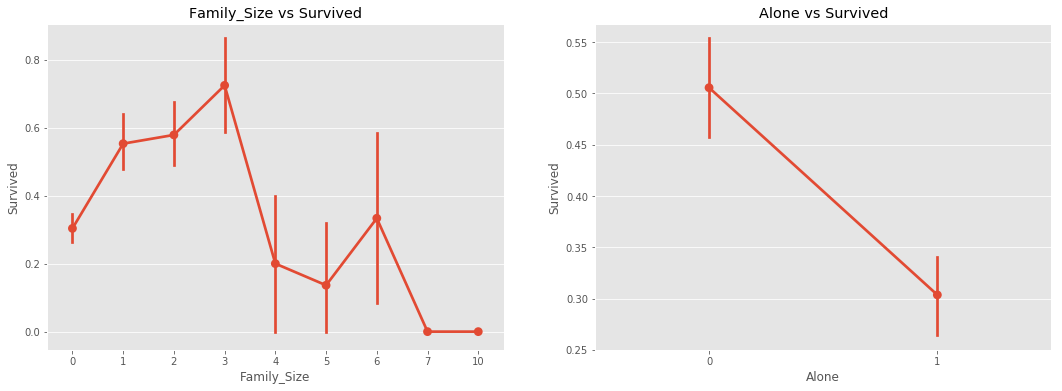

In [35]:
df['Family_Size']=0
df['Family_Size']=df['Parch']+df['SibSp']#family size
df['Alone']=0
df.loc[df.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=df,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=df,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

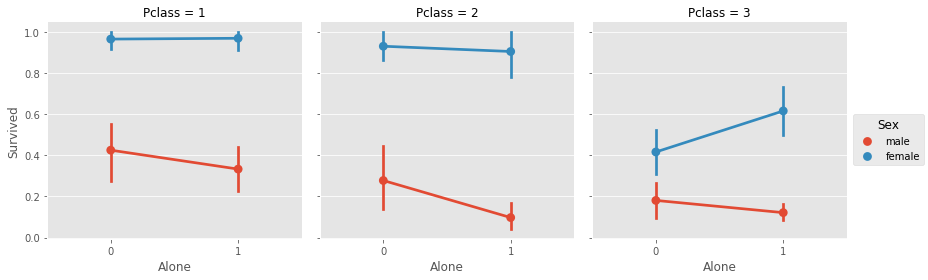

In [36]:
sns.factorplot('Alone','Survived',data=df,hue='Sex',col='Pclass')
plt.show()

In [94]:
fare_cnum = 5
df['Fare_Range'] = pd.qcut(df['Fare'], fare_cnum)    # arrange the values equally spaced into 5 seperate bins
df.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


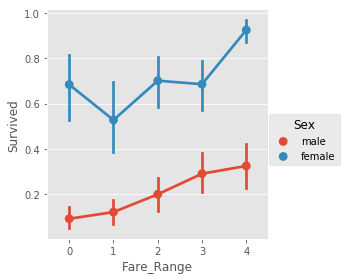

In [38]:
sns.factorplot('Fare_Range','Survived',data=df,hue='Sex')
plt.show()

In [39]:
def category_to_int(l):
    s = set(l)
    new_l = l.replace(s, range(len(s)))
    return new_l

<br>
### Dropping UnNeeded Features

<b>Name</b> --> We don't need name feature as it cannot be converted into any categorical value.

<b>Age</b> --> We have the Age_band feature, so no need of this.

<b>Ticket</b> --> It is any random string that cannot be categorised.

<b>Fare</b> </b> --> We have the Fare_cat feature, so unneeded

<b>Cabin</b> --> A lot of NaN values and also many passengers have multiple cabins. So this is a useless feature.

<b>Fare_Range</b> --> We have the fare_cat feature.

<b>PassengerId</b> --> Cannot be categorised.

In [106]:
def get_age_band(age):
    if age <= 16: return 0
    elif age <= 32: return 1
    elif age <= 48: return 2
    elif age <= 65: return 3
    else: return 4
    
def get_fare_range(x):
    if x <= 7.8: return 0
    elif x <= 10.5: return 1
    elif x <= 21.7: return 2
    elif x <= 39.7: return 3
    else: return 4
    

In [152]:
def preprocess(df):
    df['Sex'] = category_to_int(df['Sex'])
    df['Embarked'] = category_to_int(df['Embarked'])
    
    df['Title'] = df['Name'].apply(get_title).apply(transfer_title)
    df['Title'] = category_to_int(df['Title'])
    df['Age'] = [fill_age(age, name) for age, name in zip(df['Age'], df['Name'])]
    
    df['Family_Size'] = 0
    df['Family_Size'] = df['Parch'] + df['SibSp'] #family size
    df['Alone'] = 0
    df.loc[df.Family_Size==0,'Alone'] = 1 #Alone
    
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    #df['Fare_Range'] = df['Fare'].apply(get_fare_range)
    #df['Age_Band'] = df['Age'].apply(get_age_band)
    df.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
    #df.drop(['Name','Age','Ticket','Fare','Cabin'],axis=1,inplace=True)
    return df

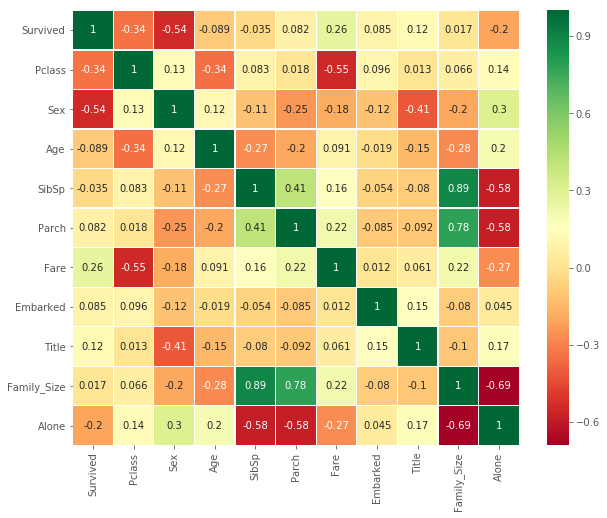

In [153]:
data = preprocess(df.copy())
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Now the above correlation plot, we can see some positively related features. Some of them being **SibSp andd Family_Size** and **Parch and Family_Size** and some negative ones like **Alone and Family_Size.**

<br>
### Feature Process

In [154]:
df = DataFrame.from_csv("res/train.csv")

<br>
### Random Forest Model

In [155]:
def get_RF_classifier(train_data, train_label, feature=[]):
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(train_data, train_label)
    feature_importance = DataFrame({'score': clf.feature_importances_}, index=feature)
    return clf, feature_importance

In [156]:
def count_acc(X_pred, y):
    c = Counter([i==j for i, j in zip(X_pred, y)])
    acc = c[1] / sum(c.values())
    return acc * 100

<br>
### K fold cross validation

In [157]:
FoldNum = 10

data = preprocess(df.copy())
data.drop(['Survived'],axis=1,inplace=True)
X = data.values
y = df['Survived'].values
kf = KFold(n_splits=FoldNum, shuffle=True)
kf.get_n_splits(X)

print(kf)  

train_acc = dev_acc = feature_importance = 0

for train_index, dev_index in kf.split(X):
    
    X_train, X_dev = X[train_index], X[dev_index]
    y_train, y_dev = y[train_index], y[dev_index]
    
    clf, _feature_importance = get_RF_classifier(X_train, y_train, data.columns)
    
    X_train_pred = clf.predict(X_train)
    X_dev_pred = clf.predict(X_dev)
    
    train_acc += count_acc(X_train_pred, y_train)
    dev_acc += count_acc(X_dev_pred, y_dev)
    feature_importance += _feature_importance

print("train-set accuracy: %0.2f" % (train_acc/FoldNum))
print("dev-set accuracy: %0.2f\n" % (dev_acc/FoldNum))
print("Feature Importance:\n", feature_importance/FoldNum, "\n")

KFold(n_splits=10, random_state=None, shuffle=True)
train-set accuracy: 81.54
dev-set accuracy: 80.59

Feature Importance:
                 score
Pclass       0.101631
Sex          0.316293
Age          0.047954
SibSp        0.013304
Parch        0.003672
Fare         0.062345
Embarked     0.015485
Title        0.325331
Family_Size  0.033366
Alone        0.080619 



<br>
<b>test-set

In [158]:
test = DataFrame.from_csv("res/test.csv")
X_test = preprocess(test)
test_pred = clf.predict(X_test.as_matrix())
result = DataFrame(test_pred, index=test.index, columns=['Survived'])
result.to_csv('result.csv')